# CRS Canada immigration metrics analysis
We investigate the Comprehensive Ranking Systme (CRS) metrics that canada uses to grant permanent residence invitations and project predicted cutoff values for the incoming cohort.

We essentially:
1. Scrub the website and create the pandas dataframe
2. Clean up the data
3. Create the preprocessing variables
4. Fit a model
5. Evaluate the goodness of fit

### Libraries to use

In [55]:
#general libraries
import os
import pickle
import mlflow
import requests
import numpy as np
import pandas as pd


#plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt


# ML models
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error


### Cleaned up functions that will be called on every model assessment

In [56]:
def create_df_from_website(url):
    ''' 
    This function scrapes data from the website and converts it to a usable pandas framework.
    '''
    # read in json filetype
    r = requests.get(url)
    rounds = r.json()['rounds']
    # remove commas from integer strings
    for r in rounds:
        for i in r:
            r[i] = r[i].replace(",", "")
    # create pandas df from dictionary
    df = pd.DataFrame.from_dict(rounds,dtype='string')
    # specify column names as needed
    columns={"drawNumber": "id", 
             "drawDate": "date", 
             "drawName": "round type", 
             "drawSize":"invitations issued", 
             "drawCRS": "CRS cutoff",
             "drawText2": "type issued",
             "drawCutOff": "tie break rule",
             "dd18": "total applications",
             "dd1":  "crs_range_601_1200",
             "dd2":  "crs_range_501_600",
             "dd3":  "crs_range_451_500",
             "dd4":  "crs_range_491_500",
             "dd5":  "crs_range_481_490",
             "dd6":  "crs_range_471_480",
             "dd7":  "crs_range_461_470",
             "dd8":  "crs_range_451_460",
             "dd9":  "crs_range_401_450",
             "dd10": "crs_range_441_450",
             "dd11": "crs_range_431_440",
             "dd12": "crs_range_421_430",
             "dd13": "crs_range_411_420",
             "dd14": "crs_range_401_410",
             "dd15": "crs_range_351_400",
             "dd16": "crs_range_301_350",
             "dd17": "crs_range_000_300",
             }
    # specify dtypes as needed
    dtypes={#"drawNumber": "id", 
            "drawDate": "datetime64[ns]", 
            #"drawName": "round type", 
            "drawSize":"int64", 
            "drawCRS": "int64",
            #"drawText2": "type issued",
            #"drawCutOff": "tie break rule",
            "dd18": "int64",
            "dd1":  "int64",
            "dd2":  "int64",
            "dd3":  "int64",
            "dd4":  "int64",
            "dd5":  "int64",
            "dd6":  "int64",
            "dd7":  "int64",
            "dd8":  "int64",
            "dd9":  "int64",
            "dd10": "int64",
            "dd11": "int64",
            "dd12": "int64",
            "dd13": "int64",
            "dd14": "int64",
            "dd15": "int64",
            "dd16": "int64",
            "dd17": "int64",
            }
    #set names and dtypes
    df = df.astype(dtype=dtypes)
    df = df.rename(columns=columns)
    # extract only columns of interest
    vars_to_keep=['date','round type','invitations issued','CRS cutoff']
    df= df[vars_to_keep]
    #setup date itself as the index
    df = df.set_index('date')

    return df

def cleanup_df_general_rounds(df):
    ''' 
    this function extracts only the general rounds and cleans up data slightly
    '''
    # combine general rounds into one type
    df["round type"] = df["round type"].replace({'No Program Specified': 'General'})
    # extract gral rounds only and remove outliers
    df = df[(df["round type"] == "General") & ((df["CRS cutoff"] < 700) & (df["CRS cutoff"] > 100))]

    return df

def calculate_date_vars(df):
    ''' 
    this function calculates extra variables based on date
    '''
    # get date column
    dates = df.index.to_series()
    # get vars
    df['month'] = dates.dt.month
    df['year'] = dates.dt.year
    df['dayofweek'] = dates.dt.dayofweek
    df['quarter'] = dates.dt.quarter

    return df


def calculate_rolling_averages(df,roll_times=['30D','60D','90D','180D']):
    ''' 
    This function calculates the rolling averages point wise for the uneven datetimes
    '''
    # flip data from oldest to newest
    df = df.iloc[::-1].copy()
    # get mean CRS in the past N months prior to this value
    for r in roll_times:
        df['roll_'+r] = df['CRS cutoff'].rolling(r, min_periods=1,closed='left').mean()
    # flip from new to old
    df = df.iloc[::-1]

    return df

def calculate_offset_windows(df,offset_value=[-1,-2,-3]):
    # remove nans so that you dont use their datetimes
    df = df.dropna().copy()
    # get date column
    dates = df.index.to_series()
    # get window per each offset values
    for offset in offset_value:
        #add previous CRS
        df['CRS'+str(offset)] = df['CRS cutoff'].shift(offset)
        #calculate quickly dt
        df['dt'+str(offset)] = dates.diff(periods=offset).abs().dt.days#.shift(offset)
    
    return df.dropna()

def calculate_independent_vars(df):
    ''' 
    this function calculates all independent variables in one go.
    '''
    # calculate rolling averages
    df = calculate_rolling_averages(df)
    # calculate offset windows
    df = calculate_offset_windows(df)
    # calculate data variables
    df = calculate_date_vars(df)

    return df

def preprocess_from_url(url):
    ''' 
    This function scrubs the url and returns a cleaned up dataframe with all independent vars
    '''
    df = create_df_from_website(url)
    df = cleanup_df_general_rounds(df)
    df = calculate_independent_vars(df)

    return df

def split_test_train(df,split_date='01-Jan-2023'):
    ''' 
    this function splits the time series into test and train data based on a cutoff date
    '''
    # get date column
    dates = df.index.to_series()
    # split it
    data_train = df.loc[dates <= split_date].copy()
    data_test = df.loc[dates > split_date].copy()
    return data_train, data_test

def create_features(data,x_labels=['dt-1','CRS-1'],y_labels=['CRS cutoff']):
    ''' 
    This function creates X and Y features
    '''
    # split in to X and Y
    X = data[x_labels]
    Y = data[y_labels]
    return X, Y

def create_split_features(df,split_date='01-Jan-2023',x_labels=['dt-1','CRS-1'],y_labels=['CRS cutoff']):
    ''' 
    This function performs in one sitting the splitting into test,train, and independent, dependent vars
    '''
    # split data according to date
    dtrain, dtest = split_test_train(df,split_date)
    # extract the labels
    X_train, y_train = dtrain[x_labels], dtrain[y_labels]
    X_test, y_test = dtest[x_labels], dtest[y_labels]

    return X_train, y_train, X_test, y_test

def fit_and_evaluate_model(X_train,y_train,X_test,y_test,type='linear'):
    ''' 
    this function fits either an XGboost or a linear model and returns model/rmse
    '''
    # select model type
    if type == 'linear':
        model = LinearRegression()
    elif type == 'xgboost':
        model = get_best_xgboost_model(X_train, y_train, X_test, y_test)
    #fit the model to the training data
    model.fit(X_train, y_train)
    # calculate the RMSE
    y_pred = y_test.copy()
    y_pred['CRS cutoff'] = model.predict(X_test)
    rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
    # return fitted model and rmse
    return model, rmse, y_pred

def get_best_xgboost_model(X_train, y_train, X_test, y_test):
    ''' 
    this function is an auxiliary as it gets the best parameters for xgboost
    '''
    #set up parameter range to search
    parameters = {
        'n_estimators': [100,250,500],
        'learning_rate': [0.01,0.05,0.1, 0.5, 0.9],
        'max_depth': [10,15,20],
        'random_state': [42]
    }
    # set up eval set
    eval_set=[(X_train, y_train), (X_test, y_test)],
    #search the grid
    model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
    clf = GridSearchCV(model, parameters)
    clf.fit(X_train, y_train)
    # establish the best parameters as the precursors for the model
    print(f'Best params: {clf.best_params_}')
    print(f'Best validation score = {clf.best_score_}')
    #output the model
    model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')

    return model

def save_model_to_pickle(model,filename='../models/lin_reg.bin'):
    ''' 
    this aux function saves the fitted model to a bin pickle file
    '''
    # create any directories if does not exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    #save file
    with open(filename, 'wb') as f_out:
        pickle.dump(model, f_out)

    return None

def plot_and_save_results(y_train,y_test,y_pred,filename='./figures/demo-file.png'):
    ''' 
    this aux function creates a pandas df plot and saves it as a png
    ''' 
    # calculates rmse
    rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
    # create any directories if does not exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # plot the figure via pandas
    ax = y_train.rename(columns={'CRS cutoff': 'Train Data'}).plot(figsize=(15, 5),title = f'rmse: {rmse:.3f}',ylabel='CRS cutoff',style='.-')
    y_test.rename(columns={'CRS cutoff': 'Test Data'}).plot(ax=ax,style='.-')
    y_pred.rename(columns={'CRS cutoff': 'Prediction from model'}).plot(ax=ax,style='.-',grid=True)
    #save the figure
    ax.figure.savefig(filename)
    return ax

## MLflow
### Initial setup
1. Need to run on terminal: `mlflow ui --backend-store-uri sqlite:///mlflow.db`
2. MLflow can be found on [http://127.0.0.1:5000/](http://127.0.0.1:5000/)
3. We set the tracking uri on the python script
4. We set the experiment name where all runs will be saved. It the exp doesn't exist mlflow will create one.

2024/07/18 04:25:49 INFO mlflow.tracking.fluent: Experiment with name 'CRS-score-canada' does not exist. Creating a new experiment.


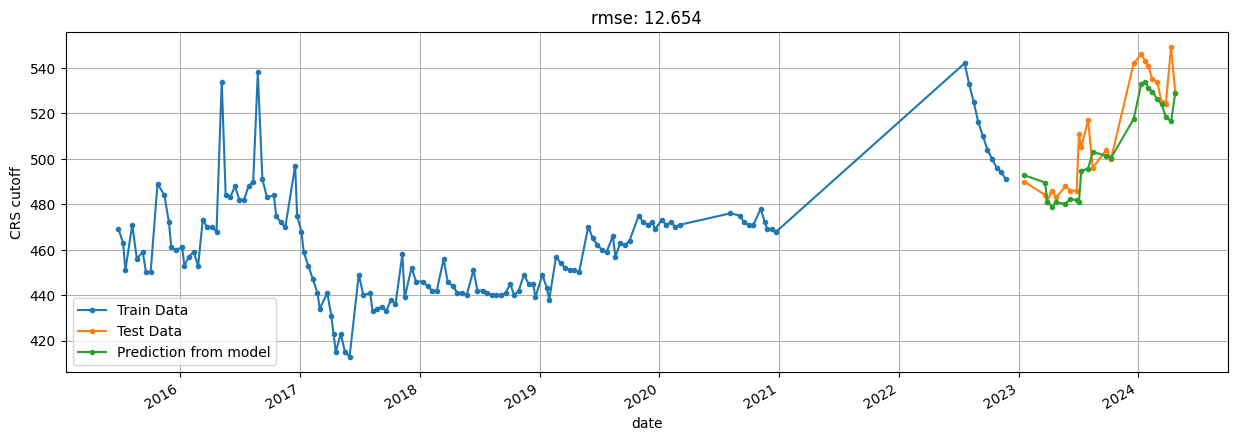

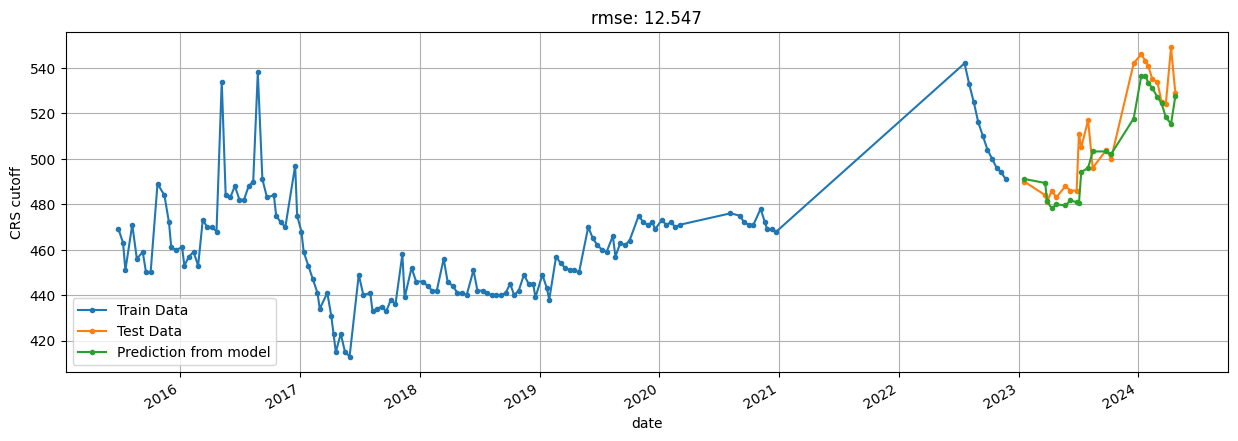

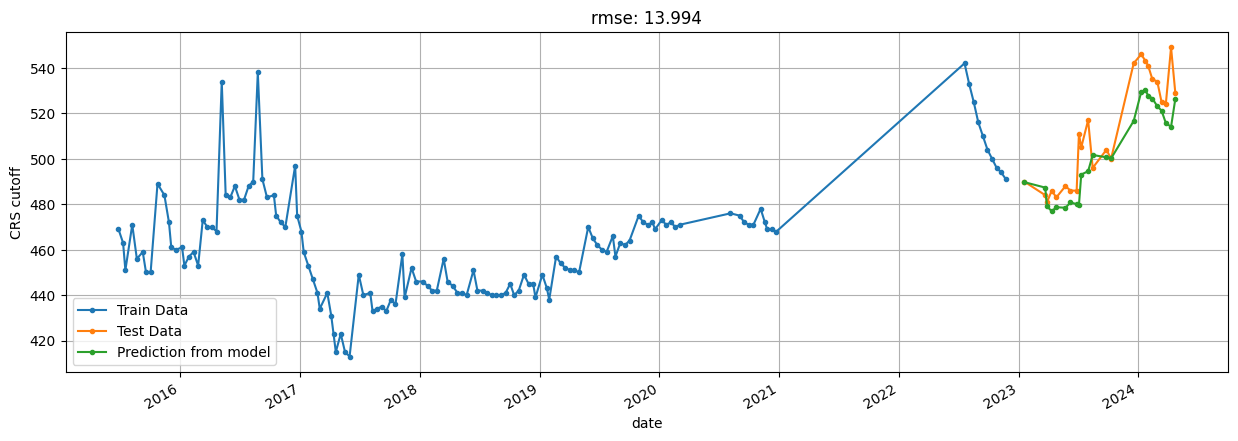

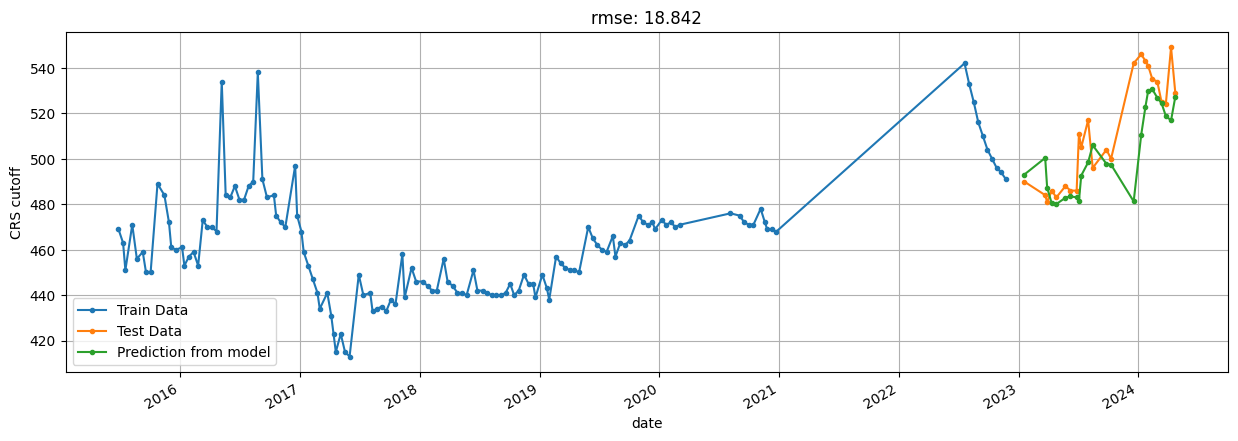

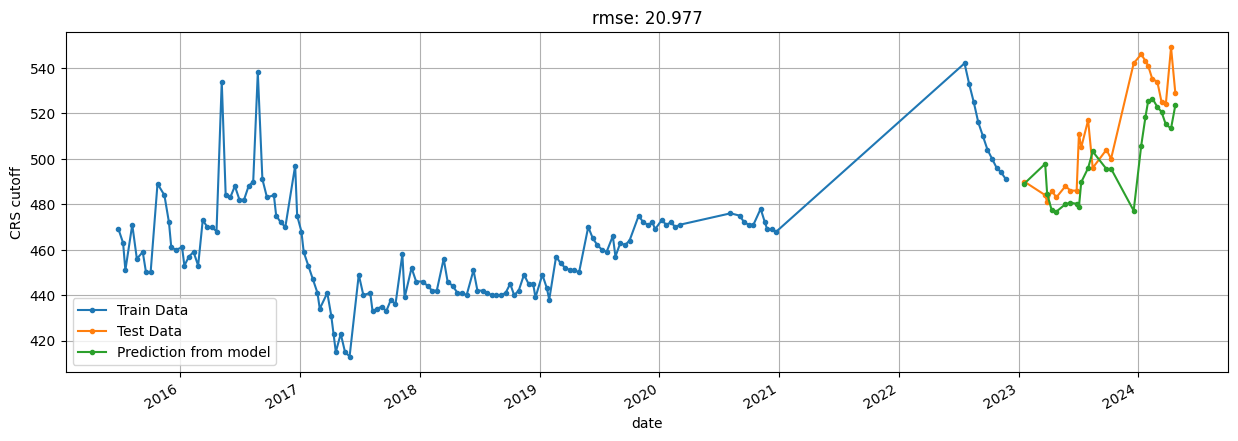

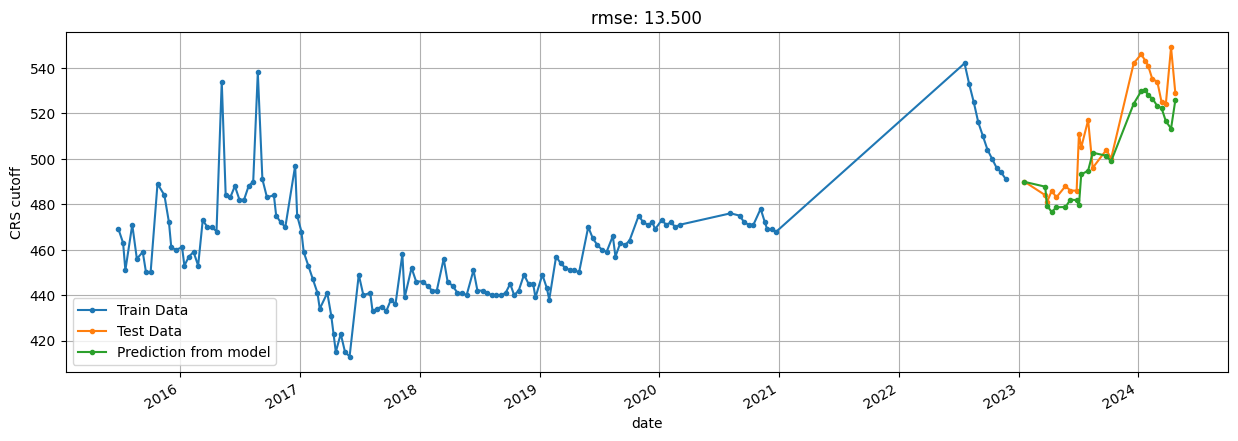

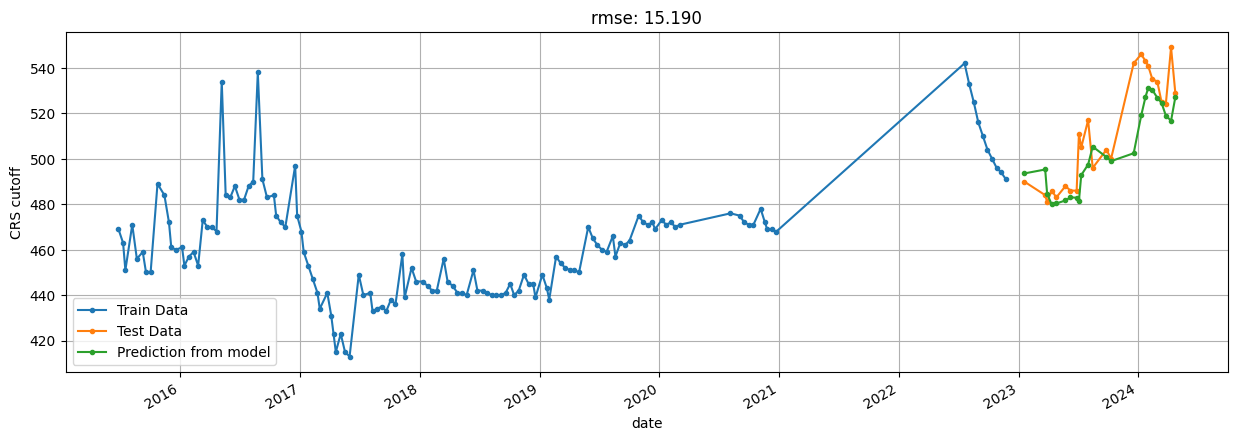

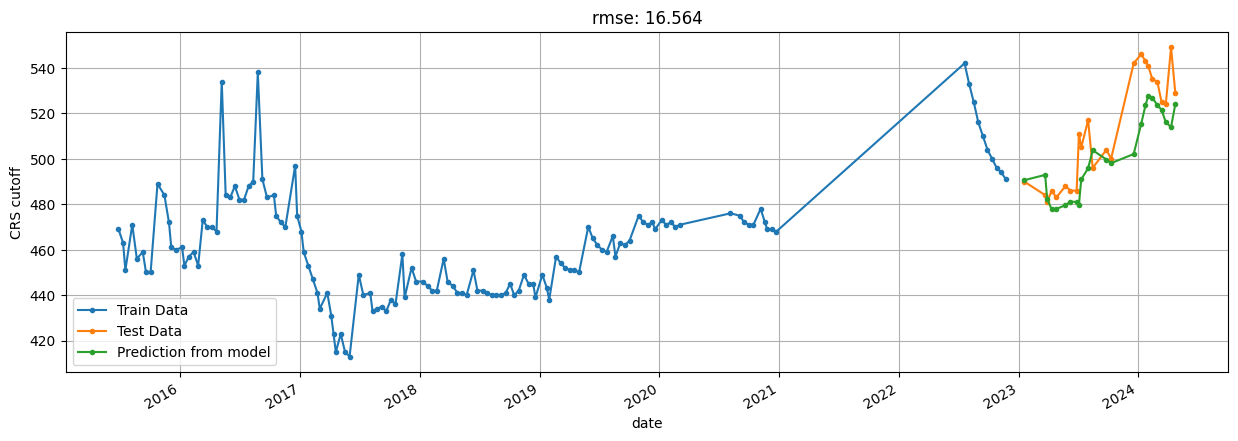

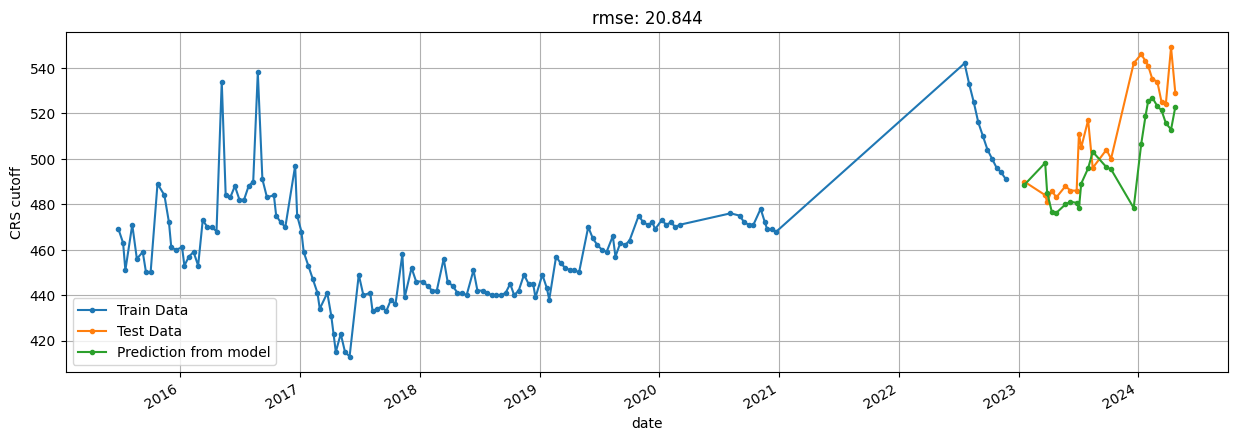

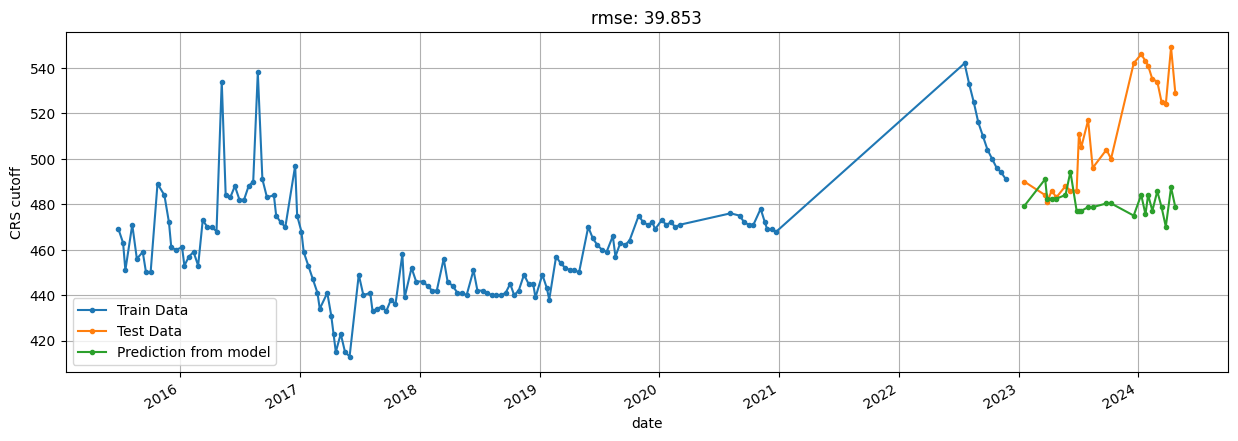

In [57]:
#mlflow setup
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("CRS-score-canada")

# preprocessing
url = 'https://www.canada.ca/content/dam/ircc/documents/json/ee_rounds_123_en.json'
df = preprocess_from_url(url)

# create features and such
split_date = '01-Jan-2023'
y_labels=['CRS cutoff']

# establish the combination of independent vars we wish to study
xlabels_combos = [
    ['roll_30D','roll_60D','roll_90D','dt-1','CRS-1'],
    ['roll_30D','roll_60D','roll_90D','roll_180D','dt-1','CRS-1'],
    ['roll_30D','roll_60D','roll_90D','dt-1','CRS-1','month','year'],
    ['roll_30D','roll_60D','roll_90D','dt-1','CRS-1','dt-2','CRS-2','dt-3','CRS-3'],
    ['roll_30D','roll_60D','roll_90D','dt-1','CRS-1','dt-2','CRS-2','dt-3','CRS-3','month','year'],
    ['roll_30D','roll_60D','dt-1','CRS-1','month','year','quarter'],
    ['dt-1','CRS-1','dt-2','CRS-2','dt-3','CRS-3'],
    ['dt-1','CRS-1','dt-2','CRS-2','dt-3','CRS-3','month','year'], 
    ['roll_30D','roll_60D','roll_90D','roll_180D','dt-1','CRS-1','dt-2','CRS-2','dt-3','CRS-3','month','year','quarter'],
    ['month','year','quarter','dayofweek'] 
]

for x_labels in xlabels_combos:
    # start a run
    with mlflow.start_run():
        # obtain features
        X_train, y_train, X_test, y_test = create_split_features(
                                            df=df,
                                            split_date=split_date,
                                            x_labels=x_labels,
                                            y_labels=y_labels
                                            )
        # model fitting
        model, rmse, y_pred = fit_and_evaluate_model(X_train,y_train,X_test,y_test,type='linear')
        # save model
        model_filename = './models/linear_model.bin'
        save_model_to_pickle(model,filename=model_filename)
        # plot fig and save as png
        figure_filename = './figures/linear_model.png'
        ax = plot_and_save_results(y_train,y_test,y_pred,filename=figure_filename)
        #register everything to mlflow
        mlflow.set_tag("type","linear-regression")
        mlflow.set_tag("developer","andrea")
        mlflow.log_param("x_labels",x_labels)
        mlflow.log_param("split_date",split_date)
        mlflow.log_metric("rmse",rmse)
        mlflow.log_artifact(local_path=model_filename, artifact_path="models")
        mlflow.log_artifact(local_path=figure_filename, artifact_path="figures")




